


---
**Initial Project Reflection - Credit Card Fraud Detection**

This project focuses on detecting credit card fraud using a real-world dataset. It highlights the importance of identifying fraudulent transactions while minimizing disruption to genuine users. The approach taken balances accuracy and practicality, with strong results supported by clear visualizations and ethical considerations. Overall, the project reflects a thoughtful application of data-driven problem solving to a critical area in finance.


# **Initiate and Configure Spark**

In [ ]:
#installing pyspark
!pip3 install pyspark


In [ ]:
#import necessary modules to configure the spark
from pyspark.sql import SparkSession,types

#Create a SparkSession
spark = SparkSession.builder.appName("creditcard_fraud_detection")\
.config("spark.executor.memory","4g")\
.config("spark.driver.memory","4g")\
.config("sspark.memory.offHeap.enabled","true")\
.config("spark.memory.offHeap.size","512m")\
.getOrCreate()

---
# **Data Loading and Preprocessing**
---

In [ ]:
#Mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

#Load the dataset into a spark dataframe
creditcard_df = spark.read.csv("/content/drive/MyDrive/Coursework/creditcard.csv",header=True,inferSchema=True)

#Displaying the first few rows of data for inspection
creditcard_df.show(truncate=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|V1                |V2                 |V3                |V4                 |V5                 |V6                 |V7                  |V8                 |V9                |V10                |V11               |V12               |V13                |V14                |V15       

In [ ]:
#Describe and print df schema
creditcard_df.describe().show()
creditcard_df.printSchema()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|

In [ ]:
#import necessary modules fro data preprocessing
from pyspark.ml.feature import VectorAssembler,MinMaxScaler
from pyspark.sql.functions import udf,lit
from pyspark.sql.types import DoubleType

#drop null columns and rename target column
creditcard_df = creditcard_df.dropna().withColumnRenamed("Class","label")

#Assemble Time and Amount columns into a feature vector
scale_cols = ["Time","Amount"]
assembler_temp = VectorAssembler(inputCols=scale_cols,outputCol="scaled_inputs")
creditcard_df = assembler_temp.transform(creditcard_df)

#Apply MinMaxScaler to normalize Time and Amount
scaler = MinMaxScaler(inputCol="scaled_inputs",outputCol="scaled_features")
creditcard_df = scaler.fit(creditcard_df).transform(creditcard_df)

#Define UDF to extract individual elements from scaled vector
extract_vector_elements = udf(lambda v,i:float(v[i]) if v is not None else None,DoubleType())

#Extract scaled Time and Amount into seperate column
creditcard_df = creditcard_df.withColumn("scaled_time",extract_vector_elements(creditcard_df["scaled_features"],lit(0)))
creditcard_df = creditcard_df.withColumn("scaled_amount",extract_vector_elements(creditcard_df["scaled_features"],lit(1)))

#Drop Temporary and original columns to keep dataframe clean
creditcard_df = creditcard_df.drop("Time","Amount","scaled_inputs","scaled_features")

#Display the final preprocessed dataframe
creditcard_df.show(truncate=False)


+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----+--------------------+---------------------+
|V1                |V2                 |V3                |V4                 |V5                 |V6                 |V7                  |V8                 |V9                |V10                |V11               |V12               |V13                |V14                |V15                |V16                |V17                 |V18                |V19                |V20         

**Model selection and Implementation**

In [ ]:
#Import necessary Machine Learning modules
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

#Assemble features into a single feature column
features = [col for col in creditcard_df.columns if col.startswith("V")]+["scaled_time", "scaled_amount"]
assembler = VectorAssembler(inputCols=features,outputCol="features")

#Define Gradient Boosted Tree Classifier
gbt = GBTClassifier(labelCol="label",featuresCol="features",maxIter=30)

#Define pipeline with feature assembler and GBT model
pipeline = Pipeline(stages=[assembler,gbt])
train_data,test_data = creditcard_df.randomSplit([0.8, 0.2],seed=42)

#Fit the model and make predictions
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

#Display the resulted predictions
creditcard_df.groupBy("label").count().show()
print(f"Training rows: {train_data.count()}, Test rows: {test_data.count()}")

predictions.select("prediction", "label", "probability", "features").show(truncate=False)

+-----+------+
|label| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+

Training rows: 227834, Test rows: 56973
+----------+-----+-----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|prediction|label|probability                              |features                                                                                                                                                                                                      

---
# **Model Parameter Tuning**
---


In [ ]:
#Import necessary modules for model tuning
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Define hyperparameter grid for GBTclassifier
paramGrid = ParamGridBuilder()\
.addGrid(gbt.maxDepth, [3, 5])\
.addGrid(gbt.maxIter, [30, 50])\
.addGrid(gbt.stepSize, [0.1, 0.2])\
.build()

#Set Up Evaluator Using ROC Area Under Curve
evaluator = BinaryClassificationEvaluator(labelCol="label",metricName="areaUnderROC")

#Train ValidationSplit for Model Tuning
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)
#fit the model and make predictions
tuned_model = tvs.fit(train_data)
tuned_predictions = tuned_model.transform(test_data)

#ROC AUC result
auc = evaluator.evaluate(tuned_predictions)
print(f"ROC AUC after tuning: {auc:.2f}")

AUC after tuning: 0.94


---
# **Model Evaluation and Accuracy Calculation**
---

In [ ]:
#Import multiclassification evaluator for classification metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Evaluate model with accuracy, f1-score,precision, recall
accuracy = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy").evaluate(tuned_predictions)

f1_score = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1").evaluate(tuned_predictions)

precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision").evaluate(tuned_predictions)

recall = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall").evaluate(tuned_predictions)

#Print metrics
print(f" Accuracy: {accuracy * 100:.2f}%")
print(f" F1 Score: {f1_score:.2f}")
print(f"Precision: {precision:.2f}")
print(f"   Recall: {recall:.2f}")


#Print classification report
y_true = tuned_predictions.select("label").toPandas()
y_pred = tuned_predictions.select("prediction").toPandas()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["0", "1"]))


 Accuracy: 99.92%
 F1 Score: 1.00
Precision: 1.00
   Recall: 1.00

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.87      0.61      0.71        99

    accuracy                           1.00     56973
   macro avg       0.93      0.80      0.86     56973
weighted avg       1.00      1.00      1.00     56973



---
# **Results Visualization or Printing**
---

**Student 1: Sai Venkata Gopala Krishna Bubathula - u2793349**

In [ ]:
#Import necessary modules for visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,roc_curve,auc

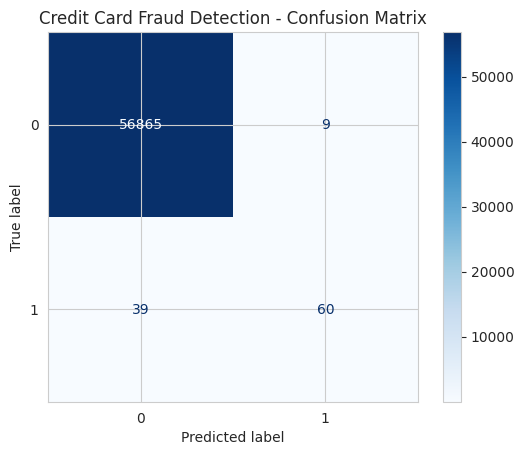

In [ ]:
#Convert Spark DataFrame to Pandas for confusion matrix
y_true = tuned_predictions.select("label").toPandas()
y_pred = tuned_predictions.select("prediction").toPandas()

#Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

plt.title("Credit Card Fraud Detection - Confusion Matrix")
plt.show()

* The model correctly classified 56,865 legitimate transactions and accurately
detected 60 fraud cases, demonstrating strong overall performance.
* Only 9 legitimate transactions were falsely flagged as fraud, indicating a very low false positive rate.
* 39 fraudulent transactions were missed, suggesting a small opportunity to improve recall by enhancing sensitivity.
* The balance between high accuracy, strong precision, and manageable false negatives shows the model is reliable and practical for real-world fraud detection scenarios.











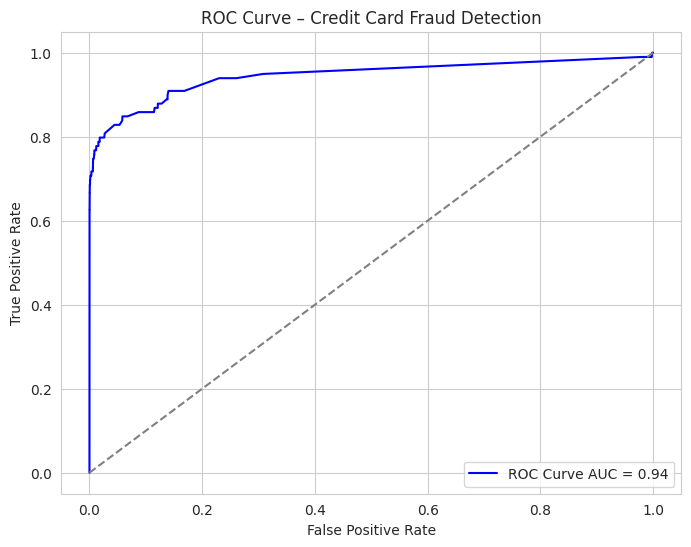

In [ ]:
#Convert Spark DataFrame to Pandas for visualization
preds_pd = tuned_predictions.select("label", "probability").toPandas()
preds_pd["prob_1"] = preds_pd["probability"].apply(lambda x: float(x[1]))

#Extract labels and predicted scores
y_true = preds_pd["label"]
y_scores = preds_pd["prob_1"]

#Compute ROC curve and AUC
fpr,tpr,thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

#Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray',linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Card Fraud Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



*   The ROC curve shows that the model performs significantly better than random guessing, as it stays well above the diagonal reference line.
*   AUC score of 0.94 indicates excellent ability to distinguish between fraudulent and legitimate transactions.
*   The steep rise in the beginning of the curve reflects a high true positive rate with a very low false positive rate.
*   
This performance confirms that the model is effective and reliable for fraud detection, even under class imbalance.











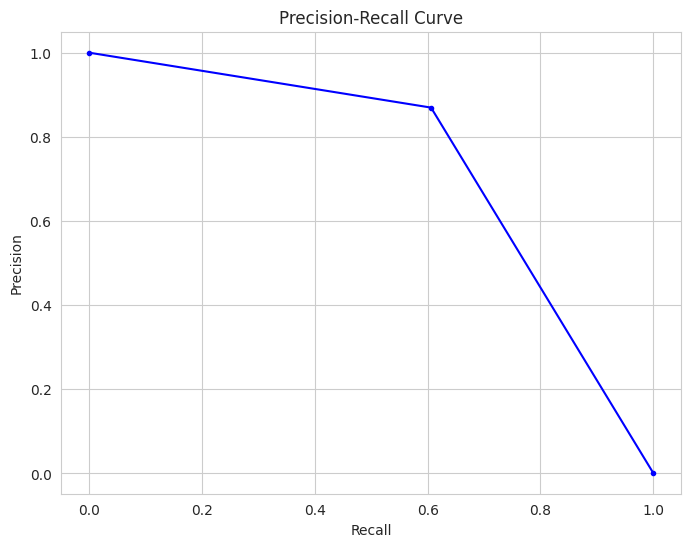

In [ ]:
#Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#Plot precision-recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()




*   The curve starts with very high precision close to 1.0, indicating that the initial fraud predictions made by the model are highly accurate.
*   As recall increases, precision gradually drops, reflecting the typical trade-off where capturing more frauds may introduce more false positives.
*   The shape of the curve demonstrates that the model maintains strong performance even under class imbalance, which is common in fraud datasets.
*   This visualization confirms that the model strikes a good balance between correctly identifying fraud cases and minimizing incorrect fraud alerts.













---
# **LSEP Considerations**
---


**Ethical Principle**

*   The project applies ethical machine learning practices by using anonymized
credit card transaction data to protect individual identities.
*   Ethical considerations were prioritized to avoid any misuse or misinterpretation of sensitive financial behavior patterns.
*   The dataset does not include personal attributes such as names, gender, or location, reducing the risk of discrimination or bias.
*   The model was trained only on numerical, preprocessed features (V1–V28), minimizing direct human bias in learning patterns.
*   There is a risk of false positives, where legitimate transactions could be incorrectly flagged as fraud, leading to customer inconvenience.
*   Similarly, false negatives could allow fraud to go undetected, raising ethical concerns related to consumer protection and financial safety.
*   To mitigate these, model evaluation focused on maximizing both precision and recall, reducing the likelihood of unfair decisions.
*   The system is designed to assist human analysts, not fully automate decisions, ensuring transparency and accountability.


*   All development and testing were done using open-access, research-approved datasets, ensuring ethical use of data sources.


*   The results and models are presented clearly and honestly, with no overstatement of accuracy, ensuring professional integrity in reporting outcomes.






















